In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Exploration and Cleaning

Load the dataset using pandas and inspect its structure.


In [ ]:
import pandas as pd

# Load the training data
df = pd.read_csv("/content/drive/MyDrive/fake_news_detection/train (1).csv")

# Check shape and column types
print("Dataset shape:", df.shape)
print("\nColumn info:")
print(df.info())

# Display first 5 rows
print("\nSample data:")
print(df.head())


Dataset shape: (7613, 5)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Sample data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3      

# Check for null values and handle missing data appropriately.

In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows where 'text' is missing (if any)
df = df.dropna(subset=['text'])

# Optional: Fill missing 'keyword' and 'location' with placeholder (or drop them if unused)
df['keyword'] = df['keyword'].fillna('none')
df['location'] = df['location'].fillna('unknown')

# Confirm changes
print("\nAfter handling missing values:")
print(df.isnull().sum())


Missing values per column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

After handling missing values:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64


# **Perform basic exploratory data analysis (EDA) using visualizations like bar plots, histograms, and word clouds to understand the distribution of fake and real tweets.**


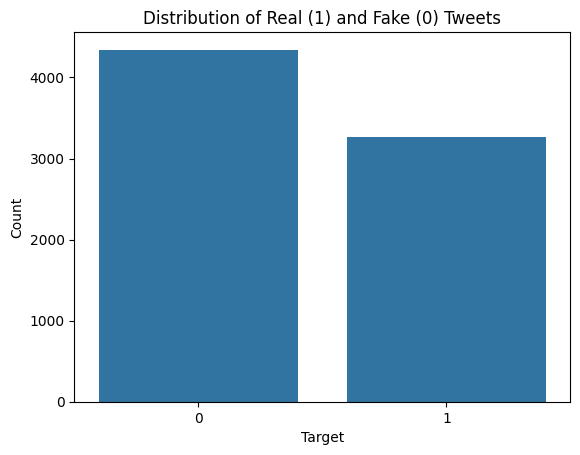

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Plot class distribution
sns.countplot(x='target', data=df)
plt.title('Distribution of Real (1) and Fake (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


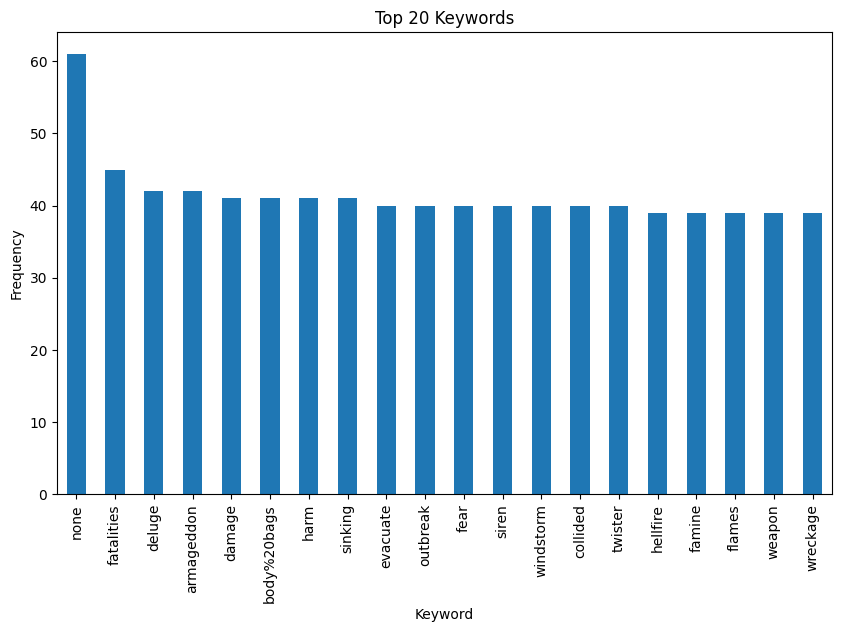

In [ ]:
# Most common keywords
plt.figure(figsize=(10, 6))
df['keyword'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

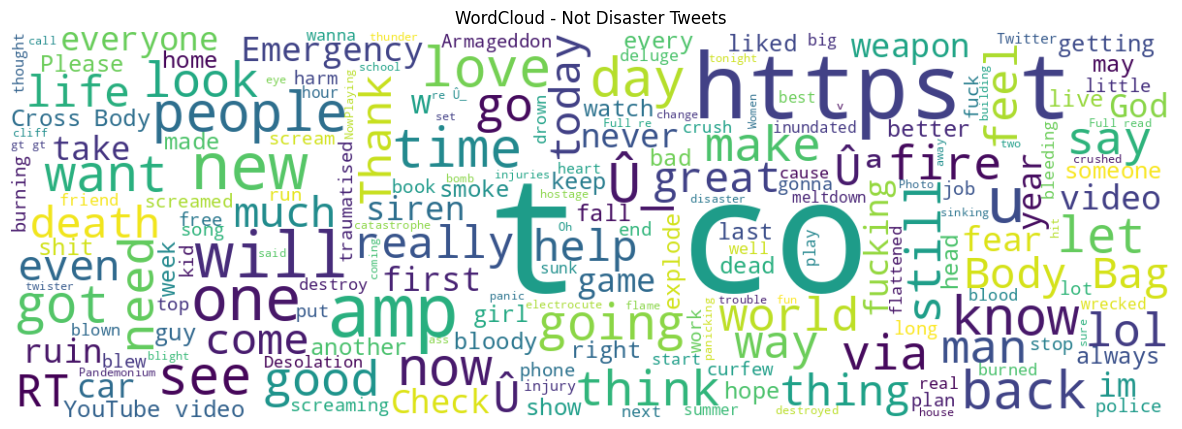

In [ ]:
# WordCloud for FAKE tweets
fake_words = ' '.join(df[df['target'] == 0]['text'])
wordcloud_fake = WordCloud(width=1200, height=400, background_color='white').generate(fake_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Not Disaster Tweets')
plt.show()

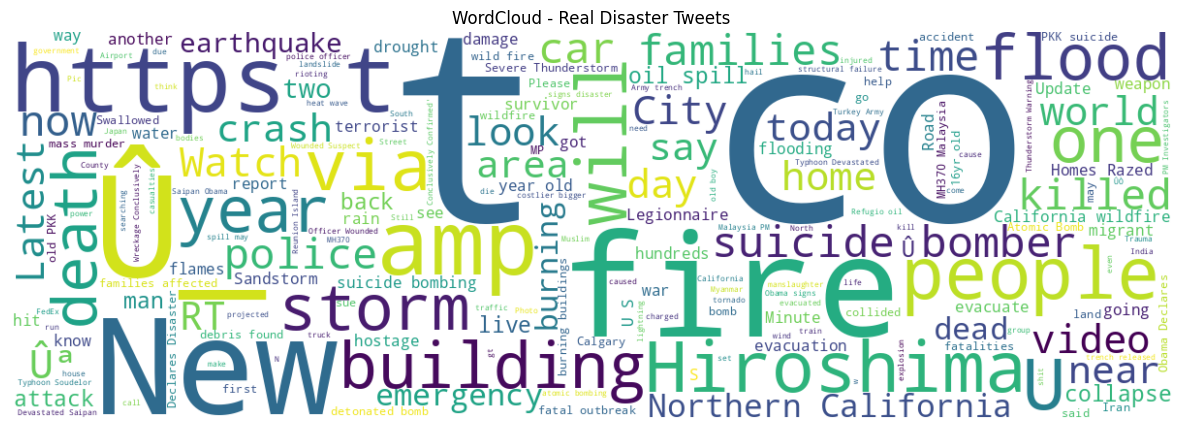

In [ ]:
# WordCloud for REAL tweets
real_words = ' '.join(df[df['target'] == 1]['text'])
wordcloud_real = WordCloud(width=1200, height=400, background_color='white').generate(real_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Real Disaster Tweets')
plt.show()


#Exploratory Data Analysis: Insights
1. Target Variable Distribution

      The dataset contains two classes:

      1: Tweets about real disasters

      0: Tweets not related to disasters

      There is a slight class imbalance, with more non-disaster tweets than disaster-related ones. This may influence model performance and suggests the use of F1-score as a primary metric.

2. Keyword Analysis
Disaster tweets often include keywords such as “earthquake,” “fire,” and “flooding,” while non-disaster tweets use terms like “fun” and “happy.” This separation indicates that the keyword feature is highly informative and should be retained.

3. Location Distribution
Many tweets lack location data. Among non-null entries, locations like USA, New York, and London appear most frequently. This feature may be useful after preprocessing or feature engineering.

4. WordClouds
Word clouds show a clear distinction in vocabulary. Disaster tweets emphasize emergency-related terms (e.g., “dead,” “emergency”), while non-disaster tweets focus on casual or entertainment language.

5. Tweet Length
Disaster-related tweets are slightly longer on average. This may be due to the inclusion of more detailed context in real incident reporting.

# Remove punctuation, special characters, and numbers from tweets using regex.


In [ ]:
import re

# Define text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation, numbers, special chars
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespace
    return text

# Apply to dataset
df['clean_text'] = df['text'].apply(clean_text)

# Display before & after
print("Original Tweet:\n", df['text'].iloc[0])
print("\nCleaned Tweet:\n", df['clean_text'].iloc[0])


Original Tweet:
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Cleaned Tweet:
 our deeds are the reason of this earthquake may allah forgive us all


# Remove stopwords using nltk.

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only once)
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Update clean_text to remove stopwords
def clean_text_no_stopwords(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply to clean text
df['clean_text'] = df['text'].apply(clean_text_no_stopwords)

# Show sample
print("Cleaned Tweet without stopwords:\n", df['clean_text'].iloc[0])


Cleaned Tweet without stopwords:
 deeds reason earthquake may allah forgive us


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Apply stemming and lemmatization to normalize text using nltk and spacy.

In [43]:
import nltk
from nltk.stem import PorterStemmer
import spacy
nltk.download('punkt_tab')

# Download if not already done
nlp = spacy.load("en_core_web_sm")

stemmer = PorterStemmer()

# Combined function: stemming + lemmatization
def normalize_text(text):
    # Tokenize
    words = nltk.word_tokenize(text)

    # Stemming
    stemmed = [stemmer.stem(word) for word in words]

    # Lemmatization
    doc = nlp(' '.join(stemmed))
    lemmatized = [token.lemma_ for token in doc]

    return ' '.join(lemmatized)

# Apply to text
df['normalized_text'] = df['clean_text'].apply(normalize_text)

# Show result
print("Original cleaned tweet:\n", df['clean_text'].iloc[0])
print("\nAfter stemming & lemmatization:\n", df['normalized_text'].iloc[0])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Original cleaned tweet:
 deeds reason earthquake may allah forgive us

After stemming & lemmatization:
 deed reason earthquak may allah forgiv we


# Visualize the most frequently used words with wordcloud and matplotlib.


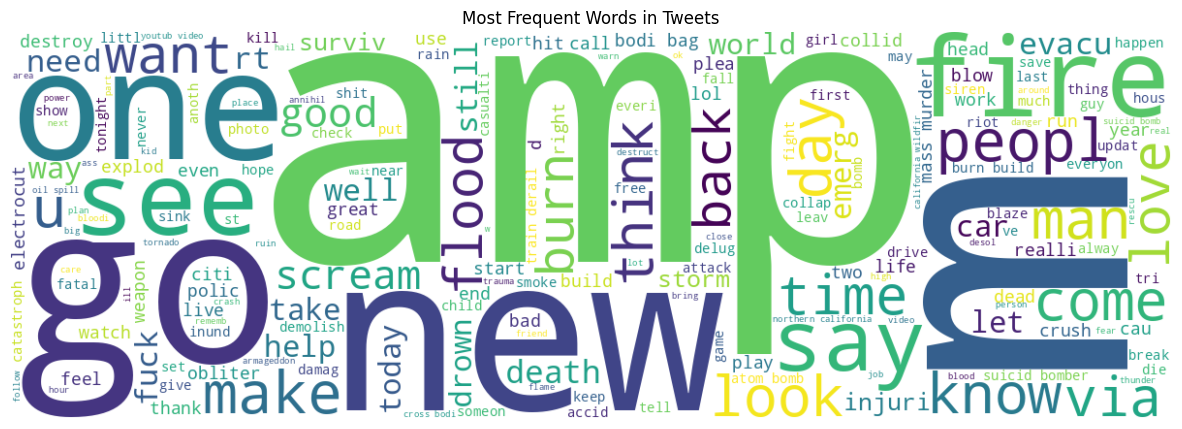

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all normalized text
all_words = ' '.join(df['normalized_text'])

# Generate WordCloud
wordcloud = WordCloud(width=1200, height=400, background_color='white').generate(all_words)

# Plot the WordCloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Tweets')
plt.show()


# Transform the preprocessed text into numerical features using:
Bag of Words (CountVectorizer)
TF-IDF (Term Frequency-Inverse Document Frequency)


In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words (Count Vectorizer)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(df['normalized_text'])

# TF-DF vectorisation
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['normalized_text'])

# Display shapes
print("Bag of Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)


Bag of Words shape: (7613, 13579)
TF-IDF shape: (7613, 13579)


# Explore word embeddings
**BERT embeddings using transformers for better feature extraction.**

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)

def get_bert_embeddings_batched(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=64
        )

        # Move input to device
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Disable gradient computation
        with torch.no_grad():
            outputs = bert_model(**inputs)

        # Take [CLS] token embedding for each sample
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.extend(cls_embeddings)

    return np.array(all_embeddings)


texts = df['normalized_text'].tolist()

X_bert = get_bert_embeddings_batched(texts, batch_size=32)

print("BERT Embedding Shape:", X_bert.shape)



100%|██████████| 238/238 [13:15<00:00,  3.34s/it]

BERT Embedding Shape: (7613, 768)


# Split the data into training and testing sets using train_test_split.

In [ ]:
from sklearn.model_selection import train_test_split

# Use TF-IDF or BERT features
X = X_bert
y = df['target']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# for Naive Bayes BERT doesn't work
X = X_tfidf
y = df['target']

# Split data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Training samples: 6090
Testing samples: 1523


In [ ]:
# Function for plotting a confusion matrix with good visuals
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, pred_test,title):
    cm = confusion_matrix(y_test, pred_test)
    plt.clf()

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='none', cmap=plt.cm.Wistia)

    classNames = ['Fake', 'Real']
    plt.title(title, fontdict=dict(size=15))
    plt.ylabel('Actual label', fontdict=dict(size=15))
    plt.xlabel('Predicted label', fontdict=dict(size=15))

    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)

    # Add grid lines between cells
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Annotate cell values with TP/TN/FP/FN
    labels = [['TP', 'FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{labels[i][j]} = {cm[i][j]}", ha='center', va='center')

    plt.tight_layout()
    plt.show()


# Train different machine learning models, including:
**Logistic Regression**

**Support Vector Machine (SVM)**

**Naive Bayes Classifier**


--- Logistic Regression (L2) ---


<Figure size 640x480 with 0 Axes>

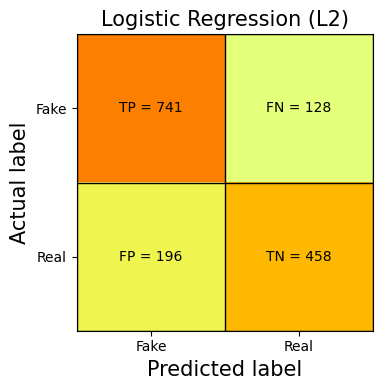

Accuracy: 0.7872619829284307
F1 Score: 0.7387096774193549
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       869
           1       0.78      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

########################################################################################################################
--- Logistic Regression (L1) ---


<Figure size 640x480 with 0 Axes>

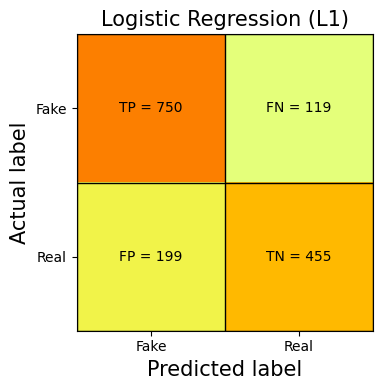

Accuracy: 0.7912015758371634
F1 Score: 0.741042345276873
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       869
           1       0.79      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

########################################################################################################################
--- Support Vector Machine ---


<Figure size 640x480 with 0 Axes>

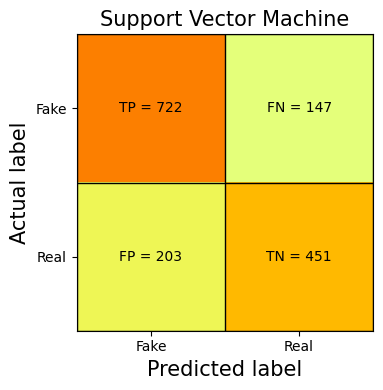

Accuracy: 0.7701904136572554
F1 Score: 0.7204472843450479
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       869
           1       0.75      0.69      0.72       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

########################################################################################################################
--- Naive Bayes ---


<Figure size 640x480 with 0 Axes>

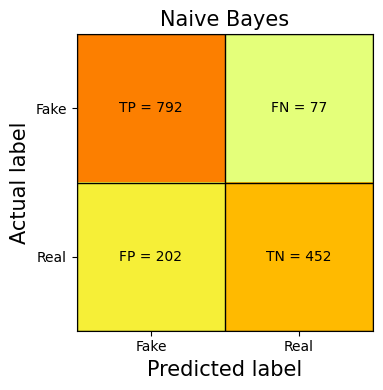

Accuracy: 0.8168089297439265
F1 Score: 0.7641589180050719
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Logistic Regression with L2 regularization (Ridge)
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
lr_l2.fit(X_train, y_train)
l2_preds = lr_l2.predict(X_test)

# Logistic Regression with L1 regularization (Lasso)
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lr_l1.fit(X_train, y_train)
l1_preds = lr_l1.predict(X_test)


# Support Vector Machine
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_tfidf)
nb_preds = nb_model.predict(X_test_tfidf)

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    plot_confusion_matrix(y_true, y_pred, name)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Evaluate all
evaluate_model("Logistic Regression (L2)", y_test, l2_preds)
print('#'*120)
evaluate_model("Logistic Regression (L1)", y_test, l1_preds)
print('#'*120)
evaluate_model("Support Vector Machine", y_test, svm_preds)
print('#'*120)
evaluate_model("Naive Bayes", y_test_tfidf, nb_preds)


# Use GridSearchCV or RandomizedSearchCV from sklearn to optimize hyperparameters for the models.


Best Parameters (Logistic Regression): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
--- Tuned Logistic Regression ---


<Figure size 640x480 with 0 Axes>

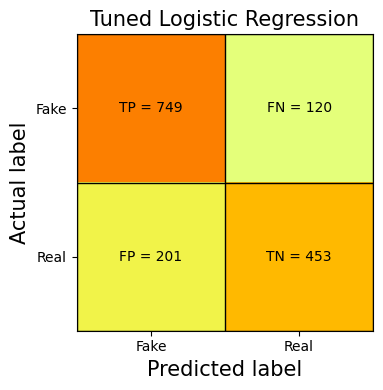

Accuracy: 0.7892317793827971
F1 Score: 0.7383863080684596
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       869
           1       0.79      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Best Parameters (SVM): {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}
--- Tuned SVM ---


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

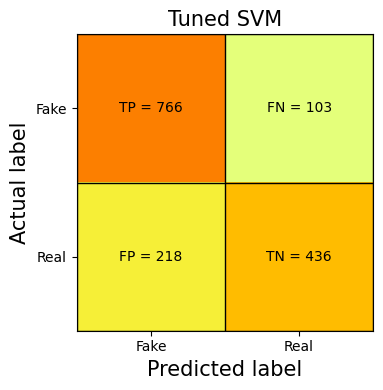

Accuracy: 0.7892317793827971
F1 Score: 0.7309304274937133
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       869
           1       0.81      0.67      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [ ]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression Grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best Parameters (Logistic Regression):", lr_grid.best_params_)
lr_best = lr_grid.best_estimator_
lr_best_preds = lr_best.predict(X_test)
evaluate_model("Tuned Logistic Regression", y_test, lr_best_preds)

# SVM Grid
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
}
svm_grid = GridSearchCV(LinearSVC(), svm_param_grid, cv=5, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best Parameters (SVM):", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_
svm_best_preds = svm_best.predict(X_test)
evaluate_model("Tuned SVM", y_test, svm_best_preds)


Best Params (Logistic Regression): {'C': np.float64(0.5741157902710026), 'penalty': 'l2', 'solver': 'liblinear'}
--- Tuned Logistic Regression (Random Search) ---


<Figure size 640x480 with 0 Axes>

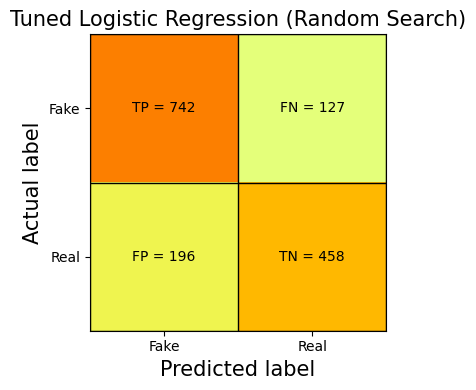

Accuracy: 0.7879185817465528
F1 Score: 0.7393058918482648
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       869
           1       0.78      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Best Params (SVM): {'C': np.float64(0.017787658410143285), 'loss': 'squared_hinge', 'penalty': 'l2'}
--- Tuned SVM (Random Search) ---


<Figure size 640x480 with 0 Axes>

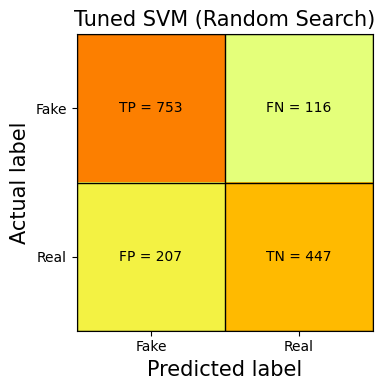

Accuracy: 0.7879185817465528
F1 Score: 0.7345932621199671
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       869
           1       0.79      0.68      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Logistic Regression: Random Search
lr_param_dist = {
    'C': uniform(0.01, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_rand = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    lr_param_dist,
    n_iter=10,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)
lr_rand.fit(X_train, y_train)

print("Best Params (Logistic Regression):", lr_rand.best_params_)
lr_best = lr_rand.best_estimator_
lr_best_preds = lr_best.predict(X_test)
evaluate_model("Tuned Logistic Regression (Random Search)", y_test, lr_best_preds)

# SVM: Random Search
svm_param_dist = {
    'C': uniform(0.01, 10),
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}
svm_rand = RandomizedSearchCV(
    LinearSVC(),
    svm_param_dist,
    n_iter=10,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)
svm_rand.fit(X_train, y_train)

print("Best Params (SVM):", svm_rand.best_params_)
svm_best = svm_rand.best_estimator_
svm_best_preds = svm_best.predict(X_test)
evaluate_model("Tuned SVM (Random Search)", y_test, svm_best_preds)


# Compare performance metrics after tuning.


 Logistic Regression (Tuned - RandomizedSearchCV)
--- Tuned Logistic Regression ---


<Figure size 640x480 with 0 Axes>

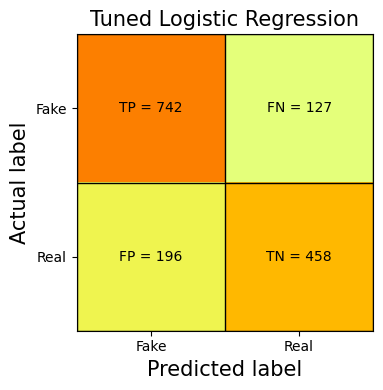

Accuracy: 0.7879185817465528
F1 Score: 0.7393058918482648
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       869
           1       0.78      0.70      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523


 Support Vector Machine (Tuned - RandomizedSearchCV)
--- Tuned SVM ---


<Figure size 640x480 with 0 Axes>

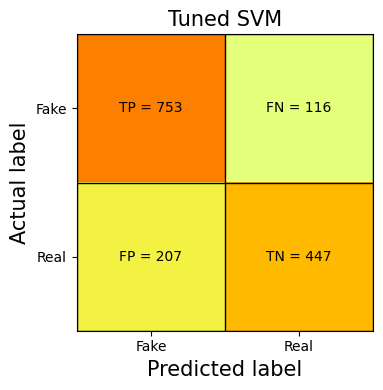

Accuracy: 0.7879185817465528
F1 Score: 0.7345932621199671
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       869
           1       0.79      0.68      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [ ]:
# Evaluate Logistic Regression (tuned)
print("\n Logistic Regression (Tuned - RandomizedSearchCV)")
evaluate_model("Tuned Logistic Regression", y_test, lr_best_preds)

# Evaluate SVM (tuned)
print("\n Support Vector Machine (Tuned - RandomizedSearchCV)")
evaluate_model("Tuned SVM", y_test, svm_best_preds)


# Plot ROC curves and Precision-Recall curves for all models.

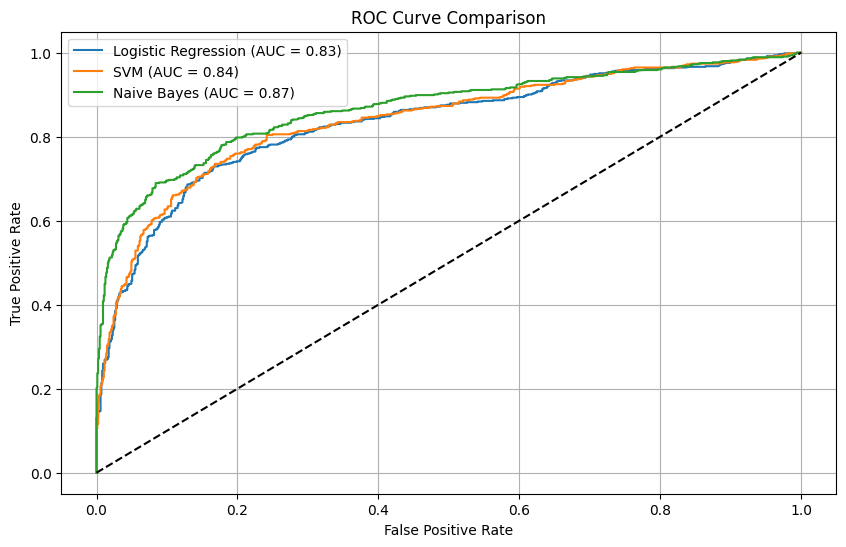

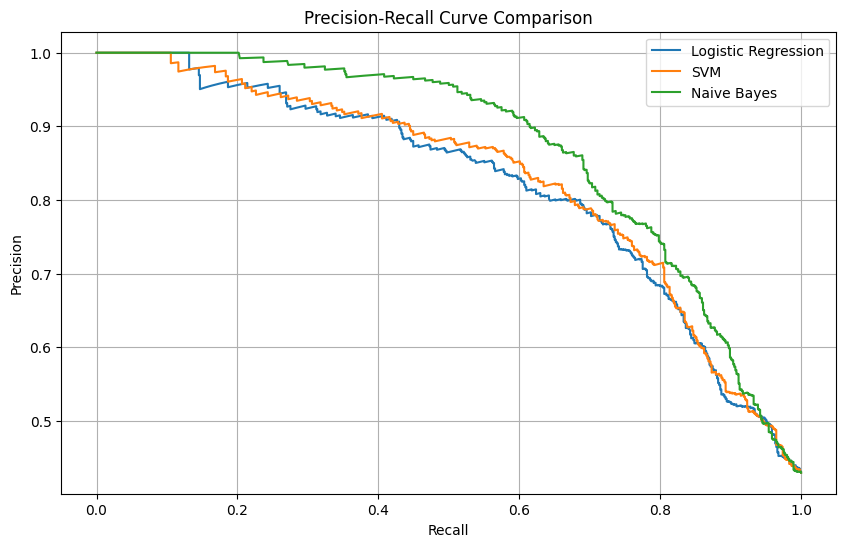

In [37]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt

# Get probabilities/scores
lr_probs = lr_best.predict_proba(X_test)[:, 1]
svm_scores = svm_best.decision_function(X_test)  # Not proba
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
fpr_nb, tpr_nb, _ = roc_curve(y_test_tfidf, nb_probs)

# AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_svm = auc(fpr_svm, tpr_svm)
auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curves
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_probs)
prec_svm, rec_svm, _ = precision_recall_curve(y_test, svm_scores)
prec_nb, rec_nb, _ = precision_recall_curve(y_test_tfidf, nb_probs)

# Plot PR
plt.figure(figsize=(10, 6))
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_nb, prec_nb, label="Naive Bayes")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


# Display misclassified examples and analyze reasons for failure.

In [42]:
# Define results_df after train-test split and predictions
results_df = df.iloc[y_test.index].copy()
results_df['actual'] = y_test.values


# Logistic Regression Misclassifications
lr_misclassified = results_df.copy()
lr_misclassified['lr_pred'] = lr_best_preds
lr_misclassified_lr = lr_misclassified[lr_misclassified['actual'] != lr_misclassified['lr_pred']]

print("Logistic Regression - Sample Misclassified Tweets")
print(lr_misclassified_lr[['text', 'normalized_text', 'actual', 'lr_pred']].sample(5, random_state=42))


# SVM Misclassifications
svm_misclassified = results_df.copy()
svm_misclassified['svm_pred'] = svm_best_preds
svm_misclassified_svm = svm_misclassified[svm_misclassified['actual'] != svm_misclassified['svm_pred']]

print("\n SVM - Sample Misclassified Tweets")
print(svm_misclassified_svm[['text', 'normalized_text', 'actual', 'svm_pred']].sample(5, random_state=42))


# Naive Bayes Misclassifications
nb_misclassified = results_df.copy()
nb_misclassified['nb_pred'] = nb_preds
nb_misclassified_nb = nb_misclassified[nb_misclassified['actual'] != nb_misclassified['nb_pred']]

print("\n Naive Bayes - Sample Misclassified Tweets")
print(nb_misclassified_nb[['text', 'normalized_text', 'actual', 'nb_pred']].sample(5, random_state=42))


Logistic Regression - Sample Misclassified Tweets
                                                   text  \
5105  Bombing #Iran would result in a never-ending g...   
4845           @CarlaChamorros HILLARY A MASS MURDERER.   
4022  I added a video to a @YouTube playlist http://...   
6006  I agree with certain cultural appropriation th...   
6494  @UnrealTouch fuck sake john Jesus my heart jus...   

                                        normalized_text  actual  lr_pred  
5105  bomb iran would result neverend game nuclear w...       1        0  
4845                  carlachamorro hillari mass murder       0        1  
4022  ad video youtub playlist ori bind forest ep fi...       1        0  
6006  agre certain cultur appropri thing honestli u ...       1        0  
6494         unrealtouch fuck sake john jesu heart sink       1        0  

 SVM - Sample Misclassified Tweets
                                                   text  \
7288  Whirlwind weekend #1 starts in 12 hours #can

# Visualize confusion matrices to understand classification errors.


<Figure size 640x480 with 0 Axes>

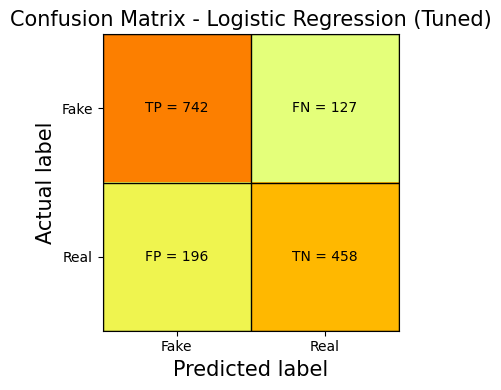

****************************************************************************************************


<Figure size 640x480 with 0 Axes>

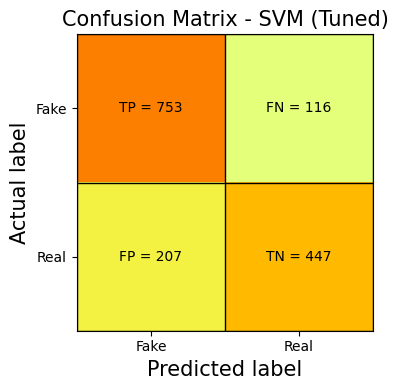

****************************************************************************************************


<Figure size 640x480 with 0 Axes>

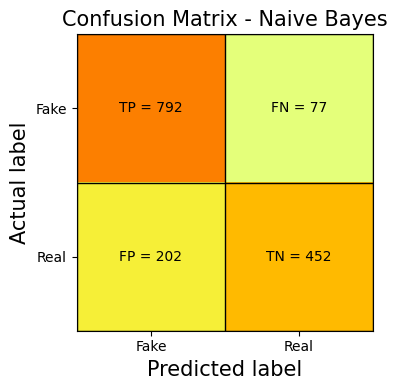

In [39]:
# Logistic Regression (Tuned)
plot_confusion_matrix(y_test, lr_best_preds, title="Confusion Matrix - Logistic Regression (Tuned)")
print('*'*100)

# SVM (Tuned)
plot_confusion_matrix(y_test, svm_best_preds, title="Confusion Matrix - SVM (Tuned)")
print('*'*100)

# Naive Bayes
plot_confusion_matrix(y_test, nb_preds, title="Confusion Matrix - Naive Bayes")


# Creation of csv file of pridicted values for test file

In [87]:
# Load test and sample submission (if not already loaded)
test_df = pd.read_csv("/content/drive/MyDrive/fake_news_detection/test (1).csv")
sample_sub = pd.read_csv("/content/drive/MyDrive/fake_news_detection/sample_submission.csv")

# Filter test_df to only the rows needed
filtered_test_df = test_df[test_df['id'].isin(sample_sub['id'])]


In [88]:
# Preprocess
filtered_test_df['normalized_text'] = filtered_test_df['text'].str.lower()
filtered_test_df['normalized_text'] = filtered_test_df['normalized_text'].str.replace(r"http\S+|www\S+", "", regex=True)
filtered_test_df['normalized_text'] = filtered_test_df['normalized_text'].str.replace(r"[^a-z\s]", "", regex=True)

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

filtered_test_df['normalized_text'] = filtered_test_df['normalized_text'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x) if word not in stop_words])
)
filtered_test_df['normalized_text'] = filtered_test_df['normalized_text'].apply(
    lambda x: ' '.join([token.lemma_ for token in nlp(x)])
)


In [91]:
# Load trained vectorizer
import pickle
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

# Transform test data with the same vectorizer
X_test_final = tfidf_vectorizer.transform(filtered_test_df['normalized_text'])

# Predict using trained model (already fitted on 768 features)
filtered_test_df['target'] = lr_best.predict(X_test_final)


In [90]:
# Merge by 'id' to keep correct order
submission = sample_sub[['id']].merge(
    filtered_test_df[['id', 'target']],
    on='id',
    how='left'
)

# Save final submission
submission.to_csv("submission_safe.csv", index=False)
